In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

def connect(poolclass=sqlalchemy.pool.QueuePool):
    with open(os.path.join(os.path.join('../..','config'), 'joco_db_profile.yaml')) as fd:
        config = yaml.load(fd)
        dburl = sqlalchemy.engine.url.URL(
            "postgres",
            host=config["host"],
            username=config["user"],
            database=config["db"],
            password=config["pass"],
            port=config["port"],
        )
        return sqlalchemy.create_engine(dburl, poolclass=poolclass)

    
conn = connect()

import SAVE_RecallAdjuster as sra
from importlib import reload
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

from jinja2 import Template

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  from ipykernel import kernelapp as app


In [2]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2018-04-01', '%Y-%m-%d')
date_pairs = []
for x in range(9,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=4*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=4*x)).strftime('%Y-%m-%d')
        )
    )

import seaborn as sns
print(date_pairs)

[('2014-04-01', '2014-04-01'), ('2014-04-01', '2015-04-01'), ('2014-08-01', '2014-08-01'), ('2014-08-01', '2015-08-01'), ('2014-12-01', '2014-12-01'), ('2014-12-01', '2015-12-01'), ('2015-04-01', '2015-04-01'), ('2015-04-01', '2016-04-01'), ('2015-08-01', '2015-08-01'), ('2015-08-01', '2016-08-01'), ('2015-12-01', '2015-12-01'), ('2015-12-01', '2016-12-01'), ('2016-04-01', '2016-04-01'), ('2016-04-01', '2017-04-01'), ('2016-08-01', '2016-08-01'), ('2016-08-01', '2017-08-01'), ('2016-12-01', '2016-12-01'), ('2016-12-01', '2017-12-01'), ('2017-04-01', '2017-04-01'), ('2017-04-01', '2018-04-01')]


In [3]:
query = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_race_2way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)

-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_white_to_nonwhite AS recall_w_to_nw,
       r.base_recall_nonwhite_to_white AS recall_nw_to_w
FROM {{schema}}.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_w_to_nw,
       r.adj_recall_nonwhite_to_white AS recall_nw_to_w
FROM {{schema}}.model_adjustment_results_race_2way r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_white_to_nonwhite AS recall_w_to_nw,
       r.adj_recall_nonwhite_to_white AS recall_nw_to_w
FROM {{schema}}.model_adjustment_results_race_2way r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_white_to_nonwhite AS recall_w_to_nw,
      r.recall_nonwhite_to_white AS recall_nw_to_w
FROM {{schema}}.composite_results_race_2way r
WHERE train_end_time > past_train_end_time
;
""")

In [4]:
query_decoupled = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_race_2way
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)


-- -- Composite model (with decoupled models)
SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_white_to_nonwhite AS recall_w_to_nw,
      recall_nonwhite_to_white AS recall_nw_to_w
FROM {{schema}}.composite_results_decoupled_race_2way
WHERE train_end_time > past_train_end_time
;
""")

In [5]:
params = {}
params['schema'] = 'joco_bias_original'
sql_orig = query.render(**params)
ts_df_orig = pd.read_sql(sql_orig, conn)

params['schema'] = 'joco_bias_nop'
sql_us = query.render(**params)
ts_df_nop = pd.read_sql(sql_us, conn)

params['schema'] = 'joco_zafar'
sql_zafar = query.render(**params)
ts_df_zafar = pd.read_sql(sql_zafar, conn)

params['schema'] = 'joco_bias_decoupled'
sql_decoupled = query_decoupled.render(**params)
ts_df_decoupled = pd.read_sql(sql_decoupled, conn)

In [6]:
#Undersampling
params = {}
params['schema'] = 'joco_bias_under_1_orig_orig'
sql_orig = query.render(**params)
ts_df_u_v1a = pd.read_sql(sql_orig, conn)

params['schema'] = 'joco_bias_under_orig_50_50'
sql_us = query.render(**params)
ts_df_u_v2a = pd.read_sql(sql_us, conn)

params['schema'] = 'joco_bias_under_orig_same_nop_orig'
sql_us = query.render(**params)
ts_df_u_v2b = pd.read_sql(sql_us, conn)

params['schema'] = 'joco_bias_under_orig_50_orig'
sql_us = query.render(**params)
ts_df_u_v2c = pd.read_sql(sql_us, conn)

params['schema'] = 'joco_bias_under_1_50_50'
sql_us = query.render(**params)
ts_df_u_v3a = pd.read_sql(sql_us, conn)

params['schema'] = 'joco_bias_under_1_same_nop_orig'
sql_us = query.render(**params)
ts_df_u_v3b = pd.read_sql(sql_us, conn)

In [7]:
#Oversampling
params = {}
params['schema'] = 'joco_bias_over_1_orig_orig'
sql_os = query.render(**params)
ts_df_o_v1a = pd.read_sql(sql_os, conn)

params['schema'] = 'joco_bias_over_orig_50_50'
sql_os = query.render(**params)
ts_df_o_v2a = pd.read_sql(sql_os, conn)

params['schema'] = 'joco_bias_over_orig_same_nop_orig'
sql_os = query.render(**params)
ts_df_o_v2b = pd.read_sql(sql_os, conn)

params['schema'] = 'joco_bias_over_orig_50_orig'
sql_os = query.render(**params)
ts_df_o_v2c = pd.read_sql(sql_os, conn)

params['schema'] = 'joco_bias_over_1_50_50'
sql_os = query.render(**params)
ts_df_o_v3a = pd.read_sql(sql_os, conn)

params['schema'] = 'joco_bias_over_1_same_nop_orig'
sql_os = query.render(**params)
ts_df_o_v3b = pd.read_sql(sql_os, conn)

In [8]:
ts_df_u_v1a['dataset'] = 'Under-v1a'
u_v1a_df = ts_df_u_v1a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_u_v2a['dataset'] = 'Under-v2a'
u_v2a_df = ts_df_u_v2a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_u_v2b['dataset'] = 'Under-v2b'
u_v2b_df = ts_df_u_v2b.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_u_v2c['dataset'] = 'Under-v2c'
u_v2c_df = ts_df_u_v2c.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_u_v3a['dataset'] = 'Under-v3a'
u_v3a_df = ts_df_u_v3a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_u_v3b['dataset'] = 'Under-v3b'
u_v3b_df = ts_df_u_v3b.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

In [9]:
ts_df_o_v1a['dataset'] = 'Over-v1a'
o_v1a_df = ts_df_o_v1a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_o_v2a['dataset'] = 'Over-v2a'
o_v2a_df = ts_df_o_v2a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_o_v2c['dataset'] = 'Over-v2c'
o_v2c_df = ts_df_o_v2c.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_o_v2b['dataset'] = 'Over-v2b'
o_v2b_df = ts_df_o_v2b.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_o_v3a['dataset'] = 'Over-v3a'
o_v3a_df = ts_df_o_v3a.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_o_v3b['dataset'] = 'Over-v3b'
o_v3b_df = ts_df_o_v3b.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

In [10]:
zafar_df = ts_df_zafar.rename(
    {'recall_w_to_nw': 'recall_disp',
    'frac_white': 'frac_grp1',
    'frac_nonwhite': 'frac_grp2'
    }, axis='columns')
zafar_df['dataset'] = 'Zafar'

ts_df_orig['dataset'] = 'Original'
orig_df = ts_df_orig.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_nop['dataset'] = 'NoP'
nop_df = ts_df_nop.rename(
    {'recall_w_to_nw': 'recall_disp', 
     'frac_white': 'frac_grp1', 
     'frac_nonwhite': 'frac_grp2'
    }, axis='columns')

ts_df_decoupled['dataset'] = 'Decoupled'
decoupled_df = ts_df_decoupled.rename(
    {'recall_w_to_nw': 'recall_disp',
     'frac_white': 'frac_grp1',
     'frac_nonwhite':'frac_grp2'
    }, axis='columns')

In [692]:
def plot_figure_two(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected", 
                                                                                        "Sampling (Best Equity)",
                                                                                       "Sampling (Best Precision)",
                                                                                       "Composite Adjusted",
                                                                                       "Regularization", 
                                                                                  "Post-hoc Adjustment"]).reset_index()

    unique_dfs = ["Original", "No Protected", "Sampling (Best Equity)", "Sampling (Best Precision)",
                 "Composite Adjusted", "Regularization", "Post-hoc Adjustment"]
    
    colorlist = ['#001c7f', #Original
                 '#b1400d', #No_Protected
                 '#12711c', #Best Sampling(Equity)
                 '#8c0800', #Best Sampling(Precision)
                 '#591e71', #Composite Adjustment
                 '#592f0d', #Regularization
                 '#a23582', #Post-hoc Adjustment
                 '#3c3c3c', 
                 '#b8850a', 
                 '#006374', 
                 '#001c7f', 
                 '#b1400d']

    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 12,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    #unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.set_xlim([0.5,0.58])
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)

    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.set_xlim([0.5, 0.58])
    ax.get_legend().remove()
    #print(hhandles)
    #print(llabels)
    #ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    #ax.legend(handles[1:], labels[1:], fontsize=100,
    #          bbox_to_anchor=(0, 5), loc='upper center', ncol=7, markerscale=5.0)
    

    fig.tight_layout()

In [693]:
#fig_two_df = pd.concat([orig_df, nop_df, zafar_df, decoupled_df])

filtered_original_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_original_df.loc[:,'dataset'] = 'Original'
filtered_original_df.loc[:,'strategy'] = 'No Adjustment'

filtered_adjusted_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')]
filtered_adjusted_df.loc[:,'dataset'] = 'Post-hoc Adjustment'
filtered_adjusted_df.loc[:,'strategy'] = 'Post-hoc Adjustment'

filtered_composite_df = orig_df[(orig_df['strategy'] == 'Composite Model - Adjusted')]
filtered_composite_df.loc[:,'dataset'] = 'Composite Adjusted'
filtered_composite_df.loc[:,'strategy'] = 'Composite Adjusted'

filtered_nop_df = nop_df[nop_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_nop_df.loc[:,'dataset'] = 'No Protected'
filtered_nop_df.loc[:,'strategy'] = 'No Protected'

filtered_zafar_df = zafar_df[zafar_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_zafar_df.loc[:,'dataset'] = 'Regularization'
filtered_zafar_df.loc[:,'strategy'] = 'Regularization'

best_prec_df = u_v3b_df[u_v3b_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_prec_df.loc[:,'dataset'] = 'Sampling (Best Precision)'
best_prec_df.loc[:,'strategy'] = 'Sampling (Best Precision)'

best_equity_df = o_v2a_df[o_v2a_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_equity_df.loc[:,'dataset'] = 'Sampling (Best Equity)'
best_equity_df.loc[:,'strategy'] = 'Sampling (Best Equity)'

fig_two_df = pd.concat([filtered_original_df, filtered_nop_df, filtered_zafar_df, 
                        best_prec_df, best_equity_df, filtered_adjusted_df,
                       filtered_composite_df])

fig_three_df = pd.concat([filtered_original_df, filtered_nop_df])
fig_four_df = pd.concat([filtered_original_df, filtered_zafar_df])

filtered_decoupled_df = decoupled_df[(decoupled_df['strategy'] == 'Composite w/ Decoupled - Adjusted')]
filtered_decoupled_df.loc[:,'strategy'] = 'Decoupled'
filtered_decoupled_df.loc[:,'dataset'] = 'Decoupled'

fig_five_df = pd.concat([filtered_original_df, filtered_composite_df, filtered_decoupled_df])

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


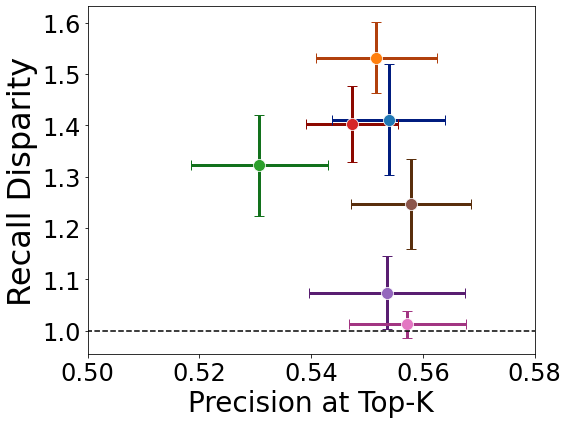

In [694]:
plot_figure_two(fig_two_df)
plt.savefig('../../PLOTS2/PLOTS_Summary/JoCo_Methods.pdf')

[<matplotlib.lines.Line2D object at 0x7f43b7917fd0>, <matplotlib.lines.Line2D object at 0x7f43b7917080>, <matplotlib.lines.Line2D object at 0x7f43b78884e0>, <matplotlib.lines.Line2D object at 0x7f43b79176d8>, <matplotlib.lines.Line2D object at 0x7f43b79179b0>, <matplotlib.lines.Line2D object at 0x7f43b7ddc438>, <matplotlib.lines.Line2D object at 0x7f43bb75a048>, <matplotlib.lines.Line2D object at 0x7f43b7888400>]
['Methods', 'Original', 'No Protected', 'Sampling (Best Equity)', 'Sampling (Best Precision)', 'Composite Adjusted', 'Regularization', 'Post-hoc Adjustment']


/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


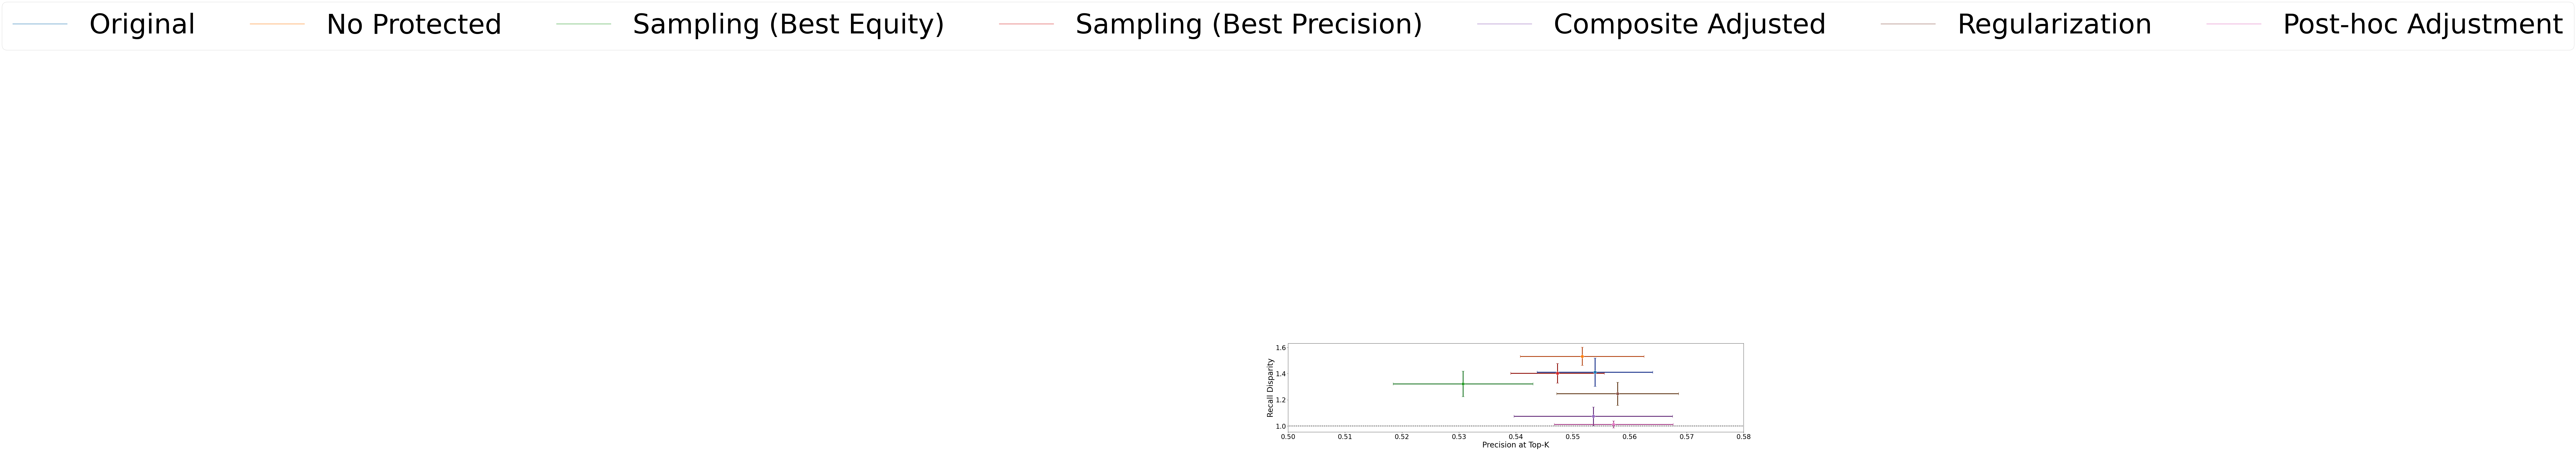

In [676]:
plot_figure_two(fig_two_df)

In [721]:
def plot_figure_three(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', #Original
                 '#b1400d']
    unique_dfs = ["Original", "No Protected"]
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "No Protected"]
        
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.025, 0.1), 
              loc='lower left', 
              borderaxespad=0., markerscale=2, ncol=1)
    ax.set_xlim([0.52, 0.58])
    fig.tight_layout()

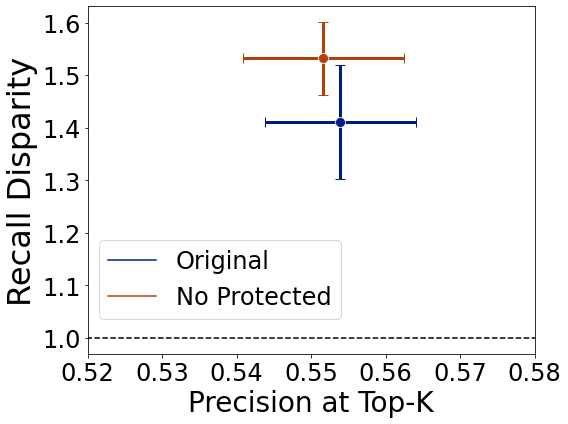

In [722]:
plot_figure_three(fig_three_df)
plt.savefig('../../PLOTS2/PLOTS_NOP/NoP_JoCo.pdf')

In [770]:
def plot_figure_four(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Regularization"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', '#592f0d'] #Regularization
    
    unique_dfs = ["Original", "Regularization"]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
    
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.015, 0.95), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)

    ax.set_xlim([0.52, 0.58])
    ax.set_ylim([0.9, 1.8])
    ax.plot([0.5, 0.6], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

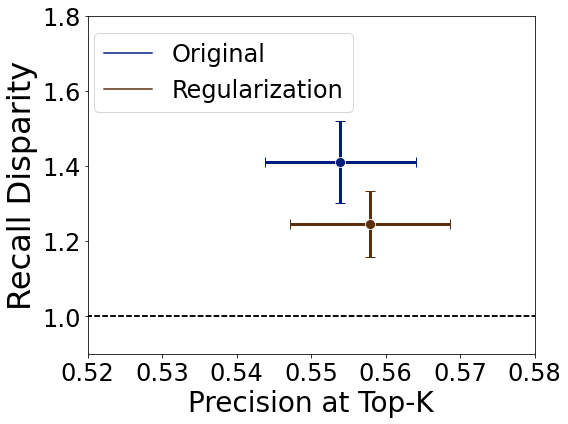

In [771]:
plot_figure_four(fig_four_df)
plt.savefig('../../PLOTS2/PLOTS_Zafar/joco_zafar.pdf')

In [748]:
def plot_figure_five(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Composite Adjusted", "Decoupled"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                 '#591e71', # Composite Adjustment
                 '#3c3c3c' # Decoupled
                ]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Composite Adjusted", "Decoupled"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.015, 0.975), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)

    ax.set_ylim([0.9, 1.65])
    ax.set_xlim([0.5, 0.58])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

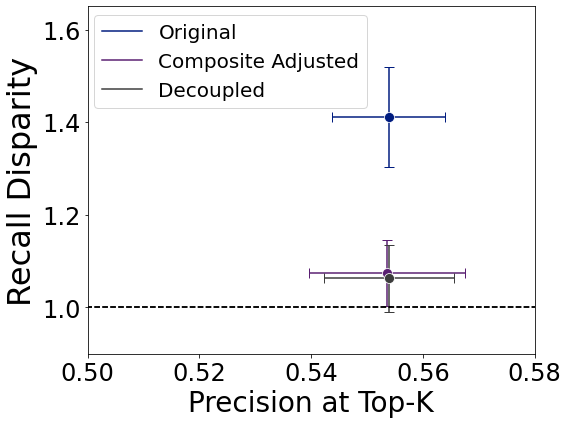

In [749]:
plot_figure_five(fig_five_df)
plt.savefig('../../PLOTS2/PLOTS_Composite/Composite_Joco.pdf')

In [455]:
def get_mode(x):
    if "Original" in x:
        return "Original"
    elif "U" in x:
        return "Under"
    return "Over"

usamp_df = pd.concat([u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
osamp_df = pd.concat([o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_usamp_df = usamp_df[(usamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_osamp_df = osamp_df[(osamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]

fig_six_df = pd.concat([filtered_orig_df, filtered_usamp_df, filtered_osamp_df])
fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Original', 'mode'] = 'Original'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'dataset'] = '6'

fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'dataset'] = '6'

fig_six_df = fig_six_df.rename(columns={"dataset": "Method", "mode":"Mode"})

In [456]:
fig_six_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()

,Method,Mode,value,recall_disp
0,Original,Original,0.553882,1.410593
1,1,Under,0.548588,1.450448
2,2,Under,0.536824,1.448317
3,3,Under,0.539059,1.637037
4,4,Under,0.520941,0.497285
5,5,Under,0.547059,1.347163
6,6,Under,0.547294,1.402818
7,1,Over,0.539412,1.378445
8,2,Over,0.530706,1.321957
9,3,Over,0.546235,1.516277


In [808]:
def plot_figure_six(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    colorlist = ['#001c7f', #Original
                 '#12711c', 
                 #'#23fab9', 
                 #'#00875e',
                 #'#3fb9c4',
                 '#a2ff00']
                 #'#688c29']
    
    data = comp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'Mode',
                 style = 'Method',
                 markers = True,
                 palette = colorlist,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = [("Original","Original"),
                  ("1","Under"), ("1","Over"),
                  ("2","Under"),("2","Over"),
                  ("3","Under"),("3","Over"),
                  ("4","Under"),("4","Over"),
                  ("5","Under"),("5","Over"),
                  ("6","Under"),("6","Over")]
    
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[(comp_df['Method'] == unique_dfs[i][0]) & (comp_df['Mode']==unique_dfs[i][1]), ].copy()
        
        x_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        
        prec_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['recall_disp'].sem().values
    
        mode = unique_dfs[i][1]
        if mode == "Original":
            color = colorlist[0]
        elif mode == "Under":
            color = colorlist[1]
        else:
            color = colorlist[2]
            
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = color, fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    #for i, lab in enumerate(labels):
    #    if lab not in list(unique_dfs):
    #        handles[i].set_linestyle("")
    #        lab = "Methods"
    #    hhandles.append(handles[i])
    #    llabels.append(lab)

    ax.legend(handles, labels, fontsize=18, 
              bbox_to_anchor=(0.015, 0.975), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.47, 0.58])
    fig.tight_layout()

In [809]:
pd.value_counts(fig_six_df['Mode'])

Over        102
Under       102
Original     17
Name: Mode, dtype: int64

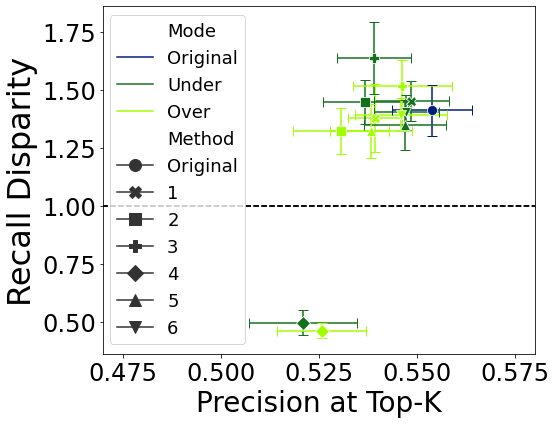

In [810]:
plot_figure_six(fig_six_df)
plt.savefig('../../PLOTS2/PLOTS_Sampling/Joco_Sampling.pdf')

In [501]:
fig_seven_df = pd.concat([filtered_orig_df, filtered_adjusted_df])

In [823]:
def plot_figure_seven(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Post-hoc Adjustment"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                '#a23582']

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Post-hoc Adjustment"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    llabels = ['Methods', 'Original', 'Post-hoc\nAdjustment']
    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.01, 0.985), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_ylim([0.9, 1.65])
    ax.set_xlim([0.53, 0.58])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    #ax.legend().remove()
    fig.tight_layout()

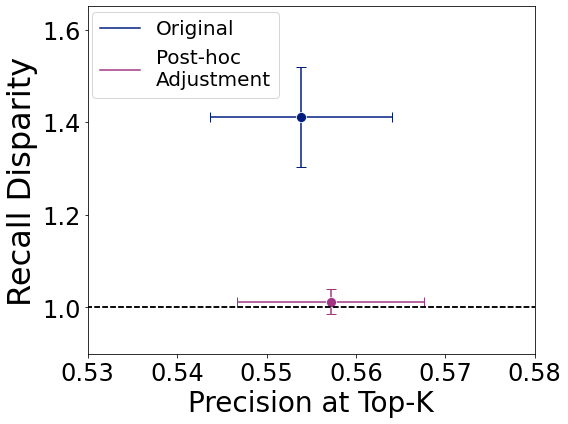

In [824]:
plot_figure_seven(fig_seven_df)
plt.savefig('../../PLOTS2/PLOTS_Post/joco_post.pdf')

In [12]:
fig_one_df = pd.concat([orig_df, nop_df, zafar_df, decoupled_df])

In [54]:
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted') 
                           | (orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')
                          | (orig_df['strategy'] == 'Composite Model - Adjusted')
                          | (orig_df['strategy'] == 'Composite Model w/ Decoupled - Adjusted')]

filtered_nop_df = nop_df[nop_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_zafar_df = zafar_df[zafar_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']

best_usamp_prec_df = u_v3b_df[(u_v3b_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
best_usamp_prec_df.loc[:,'dataset'] = 'Best UnderSample (Value)'
best_usamp_equity_df = u_v3a_df[(u_v3a_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
best_usamp_equity_df.loc[:,'dataset'] = 'Best UnderSample (Equity)'

best_osamp_prec_df = o_v2b_df[(o_v2b_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
best_osamp_prec_df.loc[:,'dataset'] = 'Best OverSample (Value)'
best_osamp_equity_df = o_v2a_df[(o_v2a_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
best_osamp_equity_df.loc[:,'dataset'] = 'Best OverSample (Equity)'

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [57]:
fig_one_df = pd.concat([filtered_orig_df, filtered_nop_df, filtered_zafar_df, best_usamp_prec_df, 
                       best_usamp_equity_df, best_osamp_prec_df, best_osamp_equity_df, decoupled_df])

fig_one_df.loc[fig_one_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_one_df.loc[fig_one_df['strategy']=='Best Unadjusted Metric - Adjusted', 'strategy'] = 'Adjusted'
fig_one_df.loc[fig_one_df['strategy']=='Composite w/ Decoupled - Adjusted','strategy'] = 'Decoupled Adjusted'
fig_one_df.loc[fig_one_df['strategy']=='Composite Model - Adjusted','strategy'] = 'Composite Adjusted'

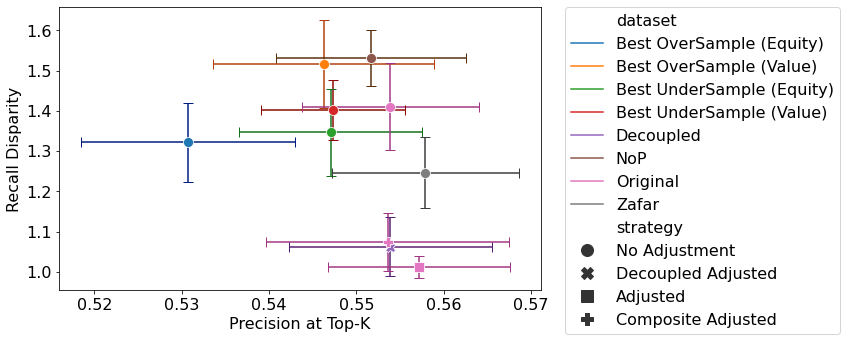

In [59]:
plot(fig_one_df)
plt.savefig('../../PLOTS2/JoCo_Summary.pdf')

In [250]:
def plot_figure_six(comp_df):
    colorlist = sns.color_palette("dark", 14).as_hex()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    data = comp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 style = 'mode',
                 markers = True,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "1", "2", "3", "4", "5", "6"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset', 'mode'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset', 'mode'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []
    for i, lab in enumerate(labels):
        if lab not in list(unique_dfs) + ['dataset', 'mode']:
            handles[i].set_linestyle("")
        hhandles.append(handles[i])
        llabels.append(lab)
        
    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.5, 0.58])
    fig.tight_layout()

In [251]:
fig_six_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reindex([
    ("Original", "Original"), ("1","Under"), ( "6", "Over")]).reset_index()

,dataset,mode,value,recall_disp
0,Original,Original,0.553882,1.410593
1,1,Under,0.548588,1.450448
2,6,Over,0.546000,1.392475


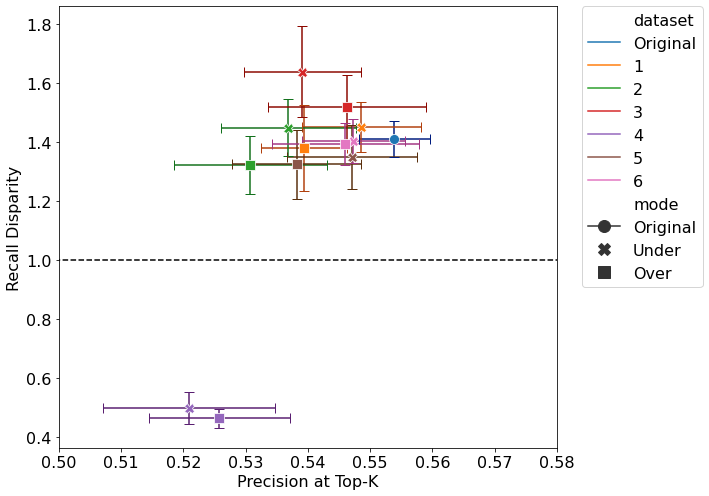

In [254]:
plot_figure_six(fig_six_df)
plt.savefig('../../PLOTS2/PLOTS_Sampling/Joco_Sampling.pdf')

In [257]:
def plot_figure_seven(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(12, 5))
    
    #data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Adjusted"]).reset_index()

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Adjusted"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.set_xlim([0.5, 0.6])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

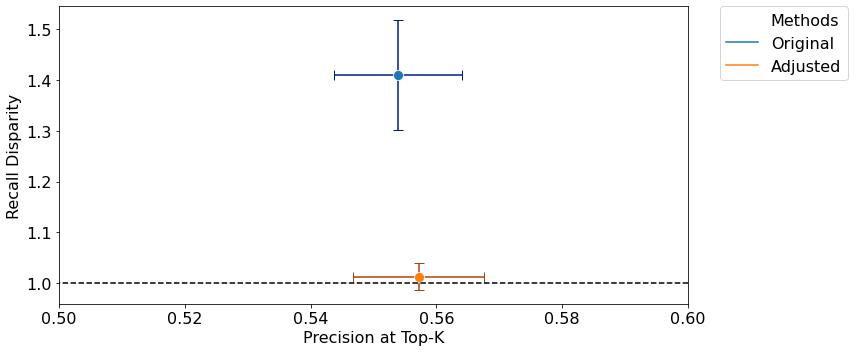

In [259]:
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')|
                          (orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')]
fig_seven_df = pd.concat([filtered_orig_df])

fig_seven_df.loc[fig_seven_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_seven_df.loc[fig_seven_df['strategy']=='Best Unadjusted Metric - Adjusted', 'strategy'] = 'Adjusted'

fig_seven_df.loc[fig_seven_df['strategy']=='No Adjustment', 'dataset'] = 'Original'
fig_seven_df.loc[fig_seven_df['strategy']=='Adjusted', 'dataset'] = 'Adjusted'

plot_figure_seven(fig_seven_df)
plt.savefig('../../PLOTS2/PLOTS_Post/joco_post.pdf')

In [261]:
colorlist = sns.color_palette("dark", 12).as_hex()
print(colorlist)

['#001c7f', '#b1400d', '#12711c', '#8c0800', '#591e71', '#592f0d', '#a23582', '#3c3c3c', '#b8850a', '#006374', '#001c7f', '#b1400d']
